# Задача: Обучение без учителя. Лямин Владимир Андреевич. Группа 22.М05

Задача
1. Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.

2. Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.

3. Самостоятельно реализуйте один из алгоритмов кластеризации, например K-means.

4. Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из sklearn (KMeans, Affinity Propogation, DBSCAN и тд).

5. При обучении использовать подбор гиперпараметров.

6. Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.

7. (+3 балла) Также снизить размерность данных с помощью метода главных компонент PCA и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.

8.  (+2 балла) Визуализировать данные снижением размерности до 2 или 3 с помощью PCA и t-SNE. В случае проблем с производительностью t-SNE, можно сначала до какой то степени снизить размерность с помощью PCA, а затем запустить t-SNE.


Информация о наборе данных: данные взяты по пациентам больным диабетом из 130 больниц США за десять лет(1999–2008). Более подробная информация: https://www.hindawi.com/journals/bmri/2014/781670/

Необходимо решить задачу кластеризации, т.е. научиться разделять данные на кластеры. В качестве целевого признака будет считать выиды пациентов.  

In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

In [11]:
df = pd.read_csv('diabetic_data.csv')

df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,150006,22864131,?,Female,[50-60),?,2,1,4,2,...,No,Down,No,No,No,No,No,Ch,Yes,NO
2,383430,80588529,Caucasian,Female,[70-80),?,1,2,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,>30
3,676422,63754317,AfricanAmerican,Female,[70-80),?,1,1,7,4,...,No,Steady,No,No,No,No,No,No,Yes,>30
4,1072554,114039603,Caucasian,Male,[70-80),?,3,1,2,3,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [12]:
df.drop(['patient_nbr'], axis=1, inplace=True)
df.drop(['encounter_id'], axis=1, inplace=True)

## Разведочный анализ (EDA)

Посмотри какие значения не заполнены

In [13]:
for col_name in df.columns.tolist():
    df[col_name].replace(["?"], [np.nan], inplace=True)

In [14]:
df.isnull().sum()

race                         113
gender                         0
age                            0
weight                      4905
admission_type_id              0
discharge_disposition_id       0
admission_source_id            0
time_in_hospital               0
payer_code                  2021
medical_specialty           2471
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_inpatient               0
diag_1                         0
diag_2                        22
diag_3                        82
number_diagnoses               0
max_glu_serum                  0
A1Cresult                      0
metformin                      0
repaglinide                    0
nateglinide                    0
chlorpropamide                 0
glimepiride                    0
acetohexamide                  0
glipizide                      0
glyburide                      0
tolbutamid

Видим, что у таких признаков как: weight,  payer_code и medical_specialty очень много пропусков. Поэтому удалим их.

In [15]:
df.drop(['weight'], axis=1, inplace=True)
df.drop(['payer_code'], axis=1, inplace=True)
df.drop(['medical_specialty'], axis=1, inplace=True)

Так как значений у нас много, то мы просто удалим строки где есть нулевые значения.

In [16]:
df.dropna(inplace=True)

### Проверим, что мы удалили все правильно

In [17]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2,Caucasian,Female,[70-80),1,2,7,1,28,0,15,...,No,Down,No,No,No,No,No,Ch,Yes,>30
3,AfricanAmerican,Female,[70-80),1,1,7,4,48,2,15,...,No,Steady,No,No,No,No,No,No,Yes,>30
4,Caucasian,Male,[70-80),3,1,2,3,29,1,7,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,Caucasian,Male,[70-80),1,11,7,9,56,2,30,...,No,Steady,No,No,No,No,No,No,Yes,NO
6,Caucasian,Female,[70-80),2,1,4,5,58,6,25,...,No,Down,No,No,No,No,No,Ch,Yes,NO


In [18]:
df.isnull().sum()

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide

### Категориальный признак race

In [19]:
df['race'].value_counts()

Caucasian          3757
AfricanAmerican     967
Hispanic             89
Other                61
Asian                23
Name: race, dtype: int64

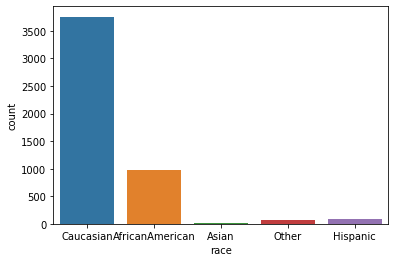

In [20]:
sns.countplot(x="race", data=df)
plt.show()

Наглядно видно, что большинство пациентов являеются европеоидами. Их больше, чем всех остальных вместе взятых.

Трансформируем строки в числа у данного признака

In [21]:
df['race'].replace(['Caucasian', 'AfricanAmerican', 'Hispanic', 'Other', 'Asian'], [0, 1, 2, 3, 4], inplace=True)

Проверяем, что мы не ошиблись

In [22]:
df['race'].value_counts()

0    3757
1     967
2      89
3      61
4      23
Name: race, dtype: int64

Так как признаков много и рассматривать их все не имеет возможности, то остальные строки преобразуем в числа автоматически

Смотрим какие у нас типы столбцов. Можно заметить, что большиснтво из них объекты

In [23]:
df.dtypes

race                         int64
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone        

In [24]:
columns = list(df.select_dtypes(include=[object]).columns)

for col in columns:
    
    elements = df[col].unique()
    values = np.arange(elements.size)
    df[col].replace(elements, values, inplace = True)

In [25]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2,0,0,0,1,2,7,1,28,0,15,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,7,4,48,2,15,...,0,1,0,0,0,0,0,1,0,0
4,0,1,0,3,1,2,3,29,1,7,...,0,1,0,0,0,0,0,0,0,1
5,0,1,0,1,11,7,9,56,2,30,...,0,1,0,0,0,0,0,1,0,1
6,0,0,0,2,1,4,5,58,6,25,...,0,0,0,0,0,0,0,0,0,1


Проверим, что операция удалась

In [26]:
df.dtypes

race                        int64
gender                      int32
age                         int32
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
time_in_hospital            int64
num_lab_procedures          int64
num_procedures              int64
num_medications             int64
number_outpatient           int64
number_emergency            int64
number_inpatient            int64
diag_1                      int32
diag_2                      int32
diag_3                      int32
number_diagnoses            int64
max_glu_serum               int32
A1Cresult                   int32
metformin                   int32
repaglinide                 int32
nateglinide                 int32
chlorpropamide              int32
glimepiride                 int32
acetohexamide               int32
glipizide                   int32
glyburide                   int32
tolbutamide                 int32
pioglitazone                int32
rosiglitazone 

Видим, что теперь у нас все столбцы целочисленны.

In [108]:
df['age'].value_counts()

0    1290
4    1121
2     831
5     795
3     435
1     193
8     124
6      94
9      12
7       2
Name: age, dtype: int64

## Обучение моделей

В первую очередб сделаем масштабирование данных

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


scaler = StandardScaler()  # воспользуемся стандартным трансформером

df_scaled  = scaler.fit_transform(df)

df_scaled = pd.DataFrame(df_scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,-0.474577,-0.913281,-1.295075,-0.715805,-0.339382,0.319271,-1.156077,-0.794785,-0.800728,-0.132623,...,0.0,-1.878077,-0.089599,0.0,0.0,0.0,0.0,-1.077090,-0.544862,-1.159912
1,1.162046,-0.913281,-1.295075,-0.715805,-0.525408,0.319271,-0.140838,0.228419,0.371694,-0.132623,...,0.0,-0.694734,-0.089599,0.0,0.0,0.0,0.0,0.928427,-0.544862,-1.159912
2,-0.474577,1.094953,-1.295075,0.668867,-0.525408,-0.900474,-0.479251,-0.743624,-0.214517,-1.121138,...,0.0,-0.694734,-0.089599,0.0,0.0,0.0,0.0,-1.077090,-0.544862,0.386953
3,-0.474577,1.094953,-1.295075,-0.715805,1.334850,0.319271,1.551227,0.637700,0.371694,1.720843,...,0.0,-0.694734,-0.089599,0.0,0.0,0.0,0.0,0.928427,-0.544862,0.386953
4,-0.474577,-0.913281,-1.295075,-0.023469,-0.525408,-0.412576,0.197575,0.740020,2.716538,1.103021,...,0.0,-1.878077,-0.089599,0.0,0.0,0.0,0.0,-1.077090,-0.544862,0.386953


### Качество кластеризации

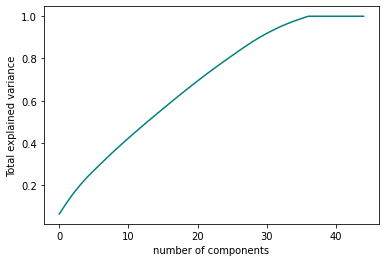

In [28]:
from sklearn.decomposition import PCA

pca = PCA().fit(df_scaled) 
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='teal') 
plt.xlabel('Number of components') 
plt.ylabel('Total explained variance'); 

Видно, что до 35 компонентов дисперсия растет быстро, а затем сильно замедляется.

Посмотрим сколько нужно компонент для сохранения 20, 40, 60 и 80 процентов информации.

In [33]:
pca = PCA(0.20).fit(df_scaled)
pca.n_components_ 

5

In [34]:
pca = PCA(0.40).fit(df_scaled)
pca.n_components_ 

11

In [35]:
pca = PCA(0.60).fit(df_scaled)
pca.n_components_ 

18

In [36]:
pca = PCA(0.80).fit(df_scaled)
pca.n_components_ 

26

Можно сделать следующие выводы:
   1. 5 компонент сохраняют 20% информации;
   2. 11 компонент сохраняют 40% информации;
   3. 18 компонент сохраняют 60% информации;
   4. 26 компонент сохраняют 80% информации;

### Реализация алгоритма K-Means

In [38]:
import numpy.typing as npt
from sklearn.base import BaseEstimator, ClusterMixin
from numpy.random import RandomState


class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_components=65, tol=1e-4):
        self.n_components = n_components
        self.tol = tol
        self.random_state = RandomState(42)
    
    
    def calculate_initial_clusters(self, X, components_number):
        return X[self.random_state.choice(len(X), size=components_number, replace=False), :]
    
        
    def calculate_clusters(self, X):
        dist_to_centers = np.linalg.norm(X[..., None] - self.cluster_centers.T, axis=1)
        return np.argmin(dist_to_centers, axis=1)
    
    
    def calculate_centers(self, X):
        new_centers = np.empty((self.n_components, self.features_number))
        for label in np.unique(self.labels_):
            new_centers[label] = np.mean(X[self.labels_ == label], axis=0)
            
        return new_centers
        
    def is_centered_cluster(self, center_position):
        return center_position <= self.tol
        
        
    def fit(self, X, y=None):
        self.features_number = X.shape[1]

        self.cluster_centers = self.calculate_initial_clusters(X, self.n_components)

        center_position = np.inf
        while not self.is_centered_cluster(center_position):
            self.labels_ = self.calculate_clusters(X)
            new_centers = self.calculate_centers(X)
            center_position = np.max(np.linalg.norm(self.cluster_centers - new_centers, axis=1))
            self.cluster_centers = new_centers

        return self

    
    def predict(self, X):
        return self.calculate_clusters(X)

### Подбор гиперпараметов

Мы будем использовать полученные ранее количество компонентов из тестов.

In [41]:
component_number = [11, 18, 26]
X_reduced = [df_scaled.to_numpy(dtype=np.float64)]
for reduced_dims in component_number:
    pca = PCA(n_components=reduced_dims)
    X_transformed = pca.fit_transform(df_scaled)
    X_reduced.append(X_transformed)

Сохранять результаты будем в файл "Results.csv". Для оценки качества будем использовать следующие метрики: silhouette_score.

In [95]:
import pathlib
import itertools
import time
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score, silhouette_score


def generate_parameters_combination(parameters):
    return [
        dict(params) for params in
        itertools.product(
            *([(name, v) for v in vs] for (name, vs) in parameters.items())
        )
    ]


def generate_result(estimator, size, best_silh):
    best_prediction_time = np.mean([best_silh[1]])
    return {
        "Cluster name": estimator.__class__.__name__,
        "Dimension": size,
        "Learning time, sec": best_prediction_time,
        "Silh": best_silh[0]
    }


def print_result(size, silh):
        print(
        f"Подбор гиперпараметров для размерности {size}:",
        f"silh: {silh[2]}",
        "",
        sep="\n",
    )
        
        
def is_better_result(best_result, cur_result):
    return best_result == None or cur_result > best_result[0]


def train(estimator, parameters = None, log=True):
    parameters = parameters if parameters is not None else {}
    param_combs = generate_parameters_combination(parameters)
    
    results = []
    for X in X_reduced:
        best_silh = None

        size = X.shape[1]
        for params in param_combs:
            cur_estimator = clone(estimator).set_params(**params)

            start_t = time.perf_counter()
            pred = cur_estimator.fit_predict(X)
            fit_predict_time = (time.perf_counter() - start_t)

            try:
                silh = silhouette_score(X, pred)
            except Exception:
                silh = 0
            if is_better_result(best_silh, silh):
                best_silh = silh, fit_predict_time, params

        if log:
            print_result(size, best_silh)
            
        results.append(generate_result(estimator, size, best_silh))

    pd.DataFrame(results).to_csv(pathlib.Path("Results.csv"), mode="a", header=not pathlib.Path("Results.csv").exists())

Обучим нашу модель

In [96]:
%%time

model = MyKMeans(n_components=11)
train(model, log=False)

Wall time: 4.1 s


### Обучение библиотечных моделей

Обучим модель KMeans

In [97]:
%%time
from sklearn.cluster import KMeans

model = KMeans(random_state=42)
hyper_parameters = {
        "algorithm": ["auto", "elkan"],
        "max_iter": [100, 200, 300],
        "n_clusters": range(2, 10)
    }

kmeans_results = train(model, hyper_parameters)
kmeans_results

Подбор гиперпараметров для размерности 45:
silh: {'algorithm': 'auto', 'max_iter': 100, 'n_clusters': 3}

Подбор гиперпараметров для размерности 11:
silh: {'algorithm': 'auto', 'max_iter': 100, 'n_clusters': 9}

Подбор гиперпараметров для размерности 18:
silh: {'algorithm': 'auto', 'max_iter': 100, 'n_clusters': 3}

Подбор гиперпараметров для размерности 26:
silh: {'algorithm': 'auto', 'max_iter': 100, 'n_clusters': 8}

Wall time: 2min 53s


Теперь обучим модель DBSCAN

In [98]:
%%time
from sklearn.cluster import DBSCAN

model = DBSCAN(n_jobs=-1)
hyper_parameters ={
    "eps": [500, 1000, 1500],
    "min_samples": [10, 50, 100],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size": [30, 50, 70]
}

dbscan_results = train(model, hyper_parameters)
dbscan_results

Подбор гиперпараметров для размерности 45:
silh: {'eps': 500, 'min_samples': 10, 'algorithm': 'auto', 'leaf_size': 30}

Подбор гиперпараметров для размерности 11:
silh: {'eps': 500, 'min_samples': 10, 'algorithm': 'auto', 'leaf_size': 30}

Подбор гиперпараметров для размерности 18:
silh: {'eps': 500, 'min_samples': 10, 'algorithm': 'auto', 'leaf_size': 30}

Подбор гиперпараметров для размерности 26:
silh: {'eps': 500, 'min_samples': 10, 'algorithm': 'auto', 'leaf_size': 30}

Wall time: 4min 47s


### Результаты

<AxesSubplot:title={'center':'Learning time, sec'}, xlabel='Dimension', ylabel='Learning time, sec'>

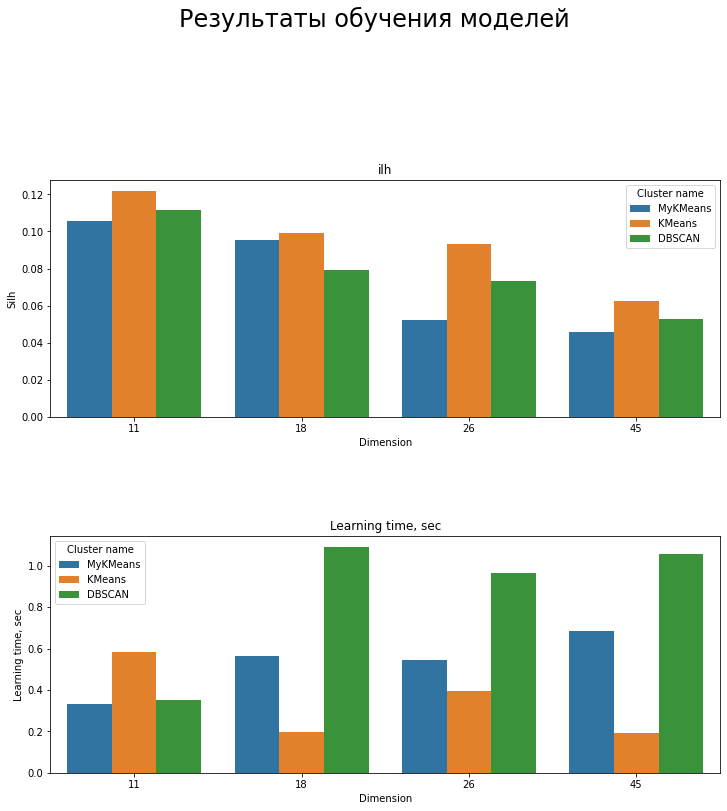

In [102]:
results = pd.read_csv(pathlib.Path("Results.csv"))

plt.figure(figsize=(12, 24))

plt.suptitle("Результаты обучения моделей", fontsize = 24)
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

plt.subplot(4, 1, 1)
plt.title("ilh")
sns.barplot(results, x="Dimension", y="Silh", hue="Cluster name")

plt.subplot(4, 1, 2)
plt.title("Learning time, sec")
sns.barplot(results, x="Dimension", y="Learning time, sec", hue="Cluster name")


### Выводы

В качестве метрики качества использовался алгоритм silhouette_score. Видно, что наилучшим оказался K-Means. DBSCAN же потребовал на свое обучение очень много времени.

## Визуализация данных снижением размерности

### Визуализация данных при момощи PCA

In [103]:
pca = PCA(n_components=2)
pca.fit(df_scaled)
X_pca = pca.transform(df_scaled)

In [104]:
df_pca = pd.DataFrame(X_pca, columns =['Component 1', 'Component 2'])
df_pca.head(2)

,Component 1,Component 2
0,-0.611811,2.195403
1,-0.105384,-0.495887


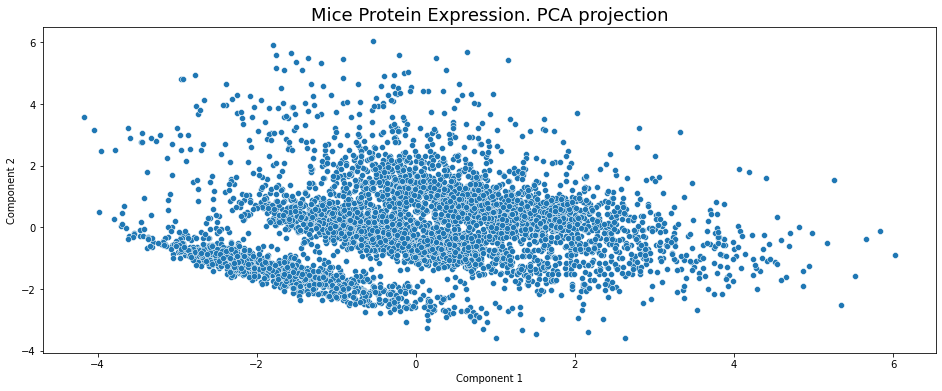

In [114]:
plt.figure(figsize=(16, 6)) 

sns.scatterplot(x = 'Component 1', y = 'Component 2', data = df_pca)
plt.title('Mice Protein Expression. PCA projection', fontsize=18)

plt.show()

На графике отчетливо видны три больших кластера. Это было ожидаемо, так как алгоритм K-Means также находил столько же кластеров.

### Визуализация данных при момощи t-SNE

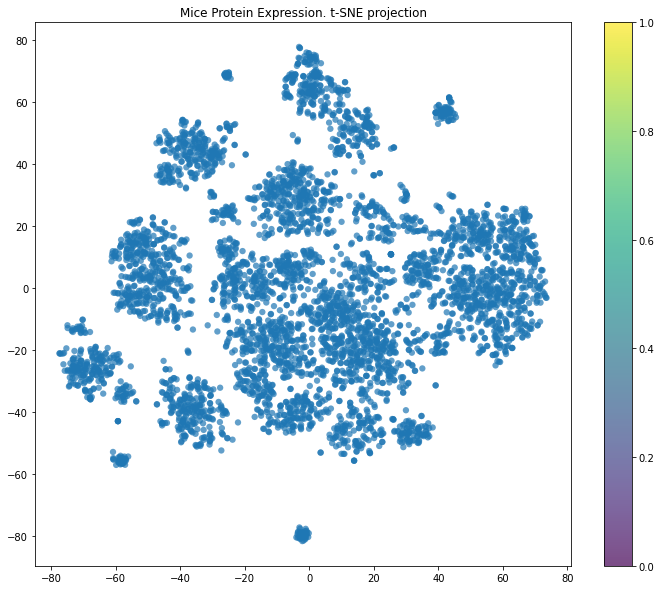

In [116]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)

X_tsne = tsne.fit_transform(df_scaled)
plt.figure(figsize=(12, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], edgecolor="none", alpha=0.7, s=40, cmap=plt.cm.get_cmap("nipy_spectral", 10),)
plt.colorbar()
plt.title("Mice Protein Expression. t-SNE projection");

Алгоритм TSNEсмог выделить больше кластеров(порядка 9). Это также является лжидаемым, так как он более продвинутый, чем PCA. Также k-Means находил 9 кластеров при своем обучении.